In [1]:
# %pip install TextBlob

# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
from textblob import TextBlob
import numpy as np


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

Training Set Head:
         Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bitt

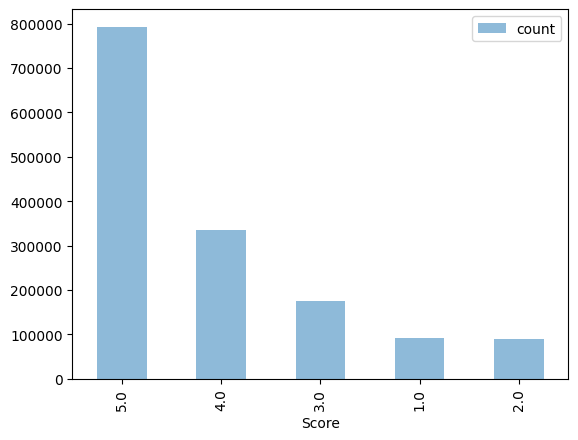


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print("\nTraining Set Head:\n", trainingSet.head())
print("\nTesting Set Head:\n", testingSet.head())

print("\nTraining Set Description:\n", trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print("\nEVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


# Adding Features

In [4]:
def add_features_to(df):
    # Add 'Helpfulness' feature
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1e-9)
        df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Add 'year' and 'is_weekend' features
    if 'Time' in df.columns:
        df['year'] = pd.to_datetime(df['Time'], unit='s').dt.year
        df['is_weekend'] = pd.to_datetime(df['Time'], unit='s').dt.dayofweek >= 5
    
    # Add sentiment features if text data exists
    if 'Summary' in df.columns and 'Text' in df.columns:
        df['summary_sentiment'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        df['text_sentiment'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    return df

trainingSet = add_features_to(trainingSet)


# Sample + Split into training and testing set

In [5]:
X = trainingSet.drop(columns=['Score', 'Id'])
y = trainingSet['Score']

# Split the training set for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Feature Selection

In [6]:
updated_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'year', 'is_weekend', 'summary_sentiment', 'text_sentiment']
updated_features = [feature for feature in updated_features if feature in X_train.columns]
X_train_select = X_train[updated_features]
X_test_select = X_test[updated_features]
X_submission_select = testingSet[['Id']].copy()


# Model Creation

In [13]:
# Drop rows with missing target (Score) values in the training set
trainingSet = trainingSet.dropna(subset=['Score'])

# Redefine X and y after dropping rows with NaN in the target column
X = trainingSet.drop(columns=['Score', 'Id'])
y = trainingSet['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Select features again for the updated X_train and X_test
updated_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'year', 'is_weekend', 'summary_sentiment', 'text_sentiment']
updated_features = [feature for feature in updated_features if feature in X_train.columns]
X_train_select = X_train[updated_features]
X_test_select = X_test[updated_features]

# Fill NaN values in the selected features
X_train_select = X_train_select.fillna(0)
X_test_select = X_test_select.fillna(0)

# Check for any remaining NaN values and print the count
print("NaN values in X_train_select:", X_train_select.isnull().sum().sum())
print("NaN values in X_test_select:", X_test_select.isnull().sum().sum())
print("NaN values in y_train:", y_train.isnull().sum())

# Proceed with model training if no NaNs are found in X and y
if X_train_select.isnull().sum().sum() == 0 and X_test_select.isnull().sum().sum() == 0 and y_train.isnull().sum() == 0:
    # Initialize and train the KNN model
    model_knn = KNeighborsClassifier(n_neighbors=21, weights='distance', metric='manhattan')
    model_knn.fit(X_train_select, y_train)
    y_test_predictions_knn = model_knn.predict(X_test_select)

    # Initialize and train the Random Forest model
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train_select, y_train)
    y_test_predictions_rf = model_rf.predict(X_test_select)
else:
    print("NaN values still exist in the dataset after handling missing values.")


NaN values in X_train_select: 0
NaN values in X_test_select: 0
NaN values in y_train: 0


# Model Evaluation

KNN Accuracy on Testing Set: 0.4954650235904949
Random Forest Accuracy on Testing Set: 0.5230626710041579
KNN Mean Absolute Error: 0.839692354094405
KNN Mean Squared Error: 1.833740870801646
Random Forest Mean Absolute Error: 0.7198898033048237
Random Forest Mean Squared Error: 1.391050154038391


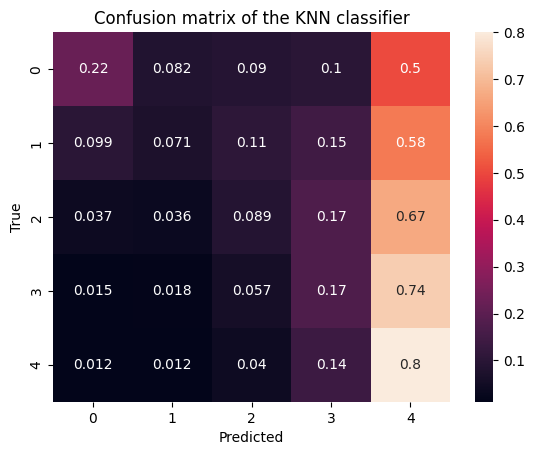

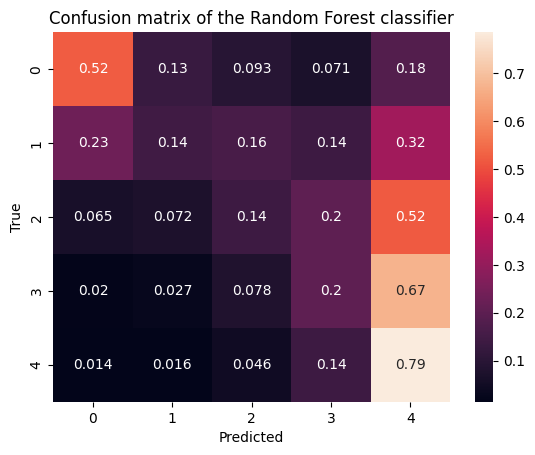

In [14]:
print("KNN Accuracy on Testing Set:", accuracy_score(y_test, y_test_predictions_knn))
print("Random Forest Accuracy on Testing Set:", accuracy_score(y_test, y_test_predictions_rf))

# Error metrics
print("KNN Mean Absolute Error:", mean_absolute_error(y_test, y_test_predictions_knn))
print("KNN Mean Squared Error:", mean_squared_error(y_test, y_test_predictions_knn))
print("Random Forest Mean Absolute Error:", mean_absolute_error(y_test, y_test_predictions_rf))
print("Random Forest Mean Squared Error:", mean_squared_error(y_test, y_test_predictions_rf))

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_test_predictions_knn, normalize='true')
sns.heatmap(cm_knn, annot=True)
plt.title('Confusion matrix of the KNN classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_test_predictions_rf, normalize='true')
sns.heatmap(cm_rf, annot=True)
plt.title('Confusion matrix of the Random Forest classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
knn_scores = cross_val_score(model_knn, X_train_select, y_train, cv=5, scoring='accuracy')
rf_scores = cross_val_score(model_rf, X_train_select, y_train, cv=5, scoring='accuracy')

print("Cross-validated KNN Accuracy:", np.mean(knn_scores))
print("Cross-validated Random Forest Accuracy:", np.mean(rf_scores))


# Create submission file

In [8]:
X_submission_select['Score'] = model_rf.predict(X_train_select[:len(X_submission_select)])  # Placeholder approach
submission = X_submission_select[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
